##### Template by Nicholas Renotte, GitHub nicknochnack

# 1. Install Dependencies and Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [3]:
import tensorflow as tf
import os

In [4]:
#to prevent out of memory error
units = tf.config.experimental.list_physical_devices('GPU')
for unit in units:
    tf.config.experimental.set_memory_growth(unit, True)

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

In [7]:
data_dir = 'data'

In [8]:
image_exits = ['jpeg','jpg', 'png']

In [ ]:
#checking folder directory and data in folder -> success
#os.listdir(data_dir)
#os.listdir(os.path.join(data_dir, 'patients'))

In [9]:
#cleaning up dodgy imgs
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exits:
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 211 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
#min 0 and max 1
batch = data_iterator.next()

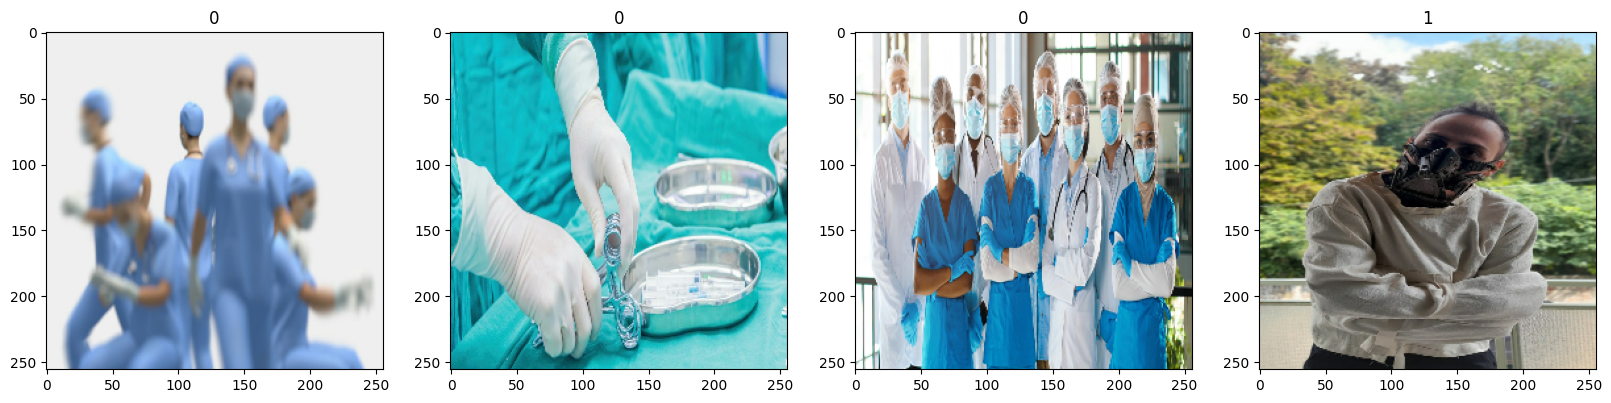

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [16]:
#x->image, y->label
data = data.map(lambda x,y: (x/255, y))

In [17]:
data.as_numpy_iterator().next()

(array([[[[0.6817249 , 0.6150582 , 0.44643077],
          [0.73147976, 0.66382504, 0.49816176],
          [0.78078276, 0.7101945 , 0.5533318 ],
          ...,
          [0.6383502 , 0.6108992 , 0.540311  ],
          [0.62352943, 0.59607846, 0.5254902 ],
          [0.62352943, 0.59607846, 0.5254902 ]],
 
         [[0.68156344, 0.6148968 , 0.4462693 ],
          [0.7295573 , 0.66190255, 0.49623927],
          [0.7788603 , 0.70827204, 0.5514093 ],
          ...,
          [0.6383915 , 0.6109405 , 0.5403523 ],
          [0.6374712 , 0.6100202 , 0.539432  ],
          [0.63698685, 0.6095359 , 0.5389476 ]],
 
         [[0.6819357 , 0.61526906, 0.44664162],
          [0.72726107, 0.65960634, 0.493943  ],
          [0.77592933, 0.7053411 , 0.54847836],
          ...,
          [0.64427334, 0.61682236, 0.54623413],
          [0.65948683, 0.63203585, 0.5614476 ],
          [0.65864736, 0.6311964 , 0.56060815]],
 
         ...,
 
         [[0.7974214 , 0.7934998 , 0.71506846],
          [0.77544

# 5. Split Data

In [ ]:
#batch number, to be divided
#len(data)

7

In [18]:
#data batches division -> 70% training, 20% validation, 10% testing
train_size = int(len(data)*.7)
validation_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [ ]:
#train_size
#validation_size
#test_size

4

In [19]:
train = data.take(train_size)
validation = data.skip(train_size).take(validation_size)
test = data.skip(train_size+validation_size).take(test_size)

# 6. Build Deep Learning Model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [21]:
seq_model = Sequential()

In [22]:
#Deep Learning model layers
#relu -> to convert negative output to 0
#sigmoid -> to get outcome 0 or 1
seq_model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
seq_model.add(MaxPooling2D())
seq_model.add(Conv2D(32, (3,3), 1, activation='relu'))
seq_model.add(MaxPooling2D())
seq_model.add(Conv2D(16, (3,3), 1, activation='relu'))
seq_model.add(MaxPooling2D())
seq_model.add(Flatten())
seq_model.add(Dense(256, activation='relu'))
seq_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
#adam keras optimizer
seq_model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [24]:
#seq_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [25]:
logdir='logs'

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [27]:
histr = seq_model.fit(train, epochs=20, validation_data=validation, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.5448 - loss: 1.2483 - val_accuracy: 0.3750 - val_loss: 0.7064
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.4844 - loss: 0.6900 - val_accuracy: 0.4688 - val_loss: 0.6937
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.6292 - loss: 0.6109 - val_accuracy: 0.8906 - val_loss: 0.5698
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.7896 - loss: 0.5618 - val_accuracy: 0.9531 - val_loss: 0.5351
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8854 - loss: 0.5075 - val_accuracy: 0.6250 - val_loss: 0.5115
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.7333 - loss: 0.4710 - val_accuracy: 0.9688 - val_loss: 0.3292
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.9219 - loss: 0.3224 - val_accuracy: 0.9375 - val_loss: 0.2335
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.8865 - loss: 0.2642 - val_accuracy: 0.8906 - val_loss: 0.2456
Epoch 9/

# 8. Plot Performance

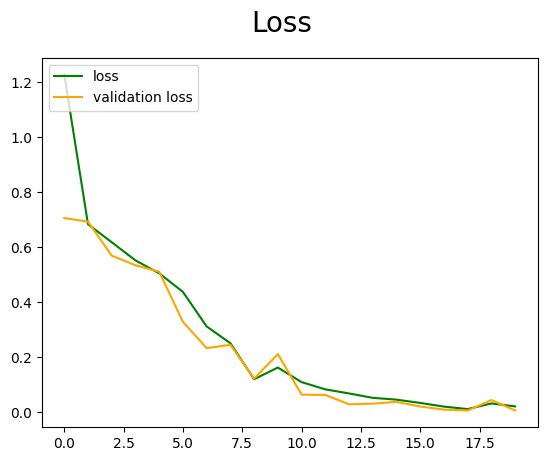

In [28]:
fig = plt.figure()
plt.plot(histr.history['loss'], color='green', label='loss')
plt.plot(histr.history['val_loss'], color='orange', label='validation loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

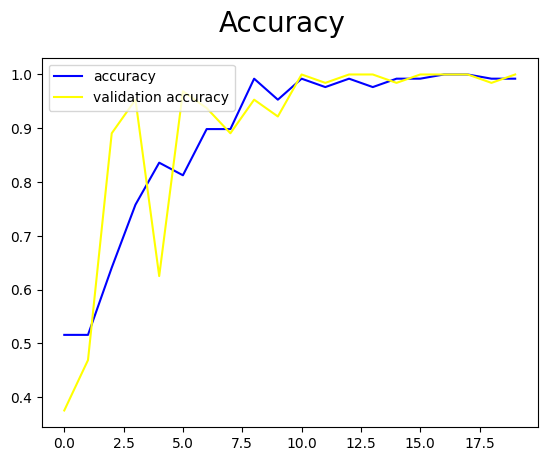

In [29]:
fig = plt.figure()
plt.plot(histr.history['accuracy'], color='blue', label='accuracy')
plt.plot(histr.history['val_accuracy'], color='yellow', label='validation accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = seq_model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [ ]:
print(pre.result(), re.result(), acc.result())

# 10. Test

In [ ]:
import cv2

In [ ]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = seq_model.predict(np.expand_dims(resize/255, 0))

In [ ]:
yhat

In [ ]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

# 11. Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
seq_model.save(os.path.join('models','imageclassifier.h5'))

In [ ]:
new_model = load_model('imageclassifier.h5')

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))